# 📚 Table of Contents

1. **Exploratory Data Analysis (EDA)**
2. **Extracting Word Features**
3. **Unsupervised Learning Method**
4. **Supervised Learning Methods**


# 1. Exploratory Data Analysis (EDA)

## 1.1 Read CSV Files into DataFrames

In [105]:
# Basic packages
import numpy as np  
import pandas as pd  

import os
import sys
import gc

from time import perf_counter 
from tqdm import tqdm
import string
import re
import warnings
warnings.simplefilter("ignore", FutureWarning)
from itertools import permutations, product, combinations
from functools import reduce

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer 
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, cross_val_score, train_test_split
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin

In [106]:
print('List of input files:')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

List of input files:
/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [107]:
train_df = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")
test_df = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")
sample_solution_df = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv")

In [108]:
train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [109]:
train_df.Text[0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [110]:
# Inspect data types and nmissing values per column
train_df.info()

# Checking number of unique articles in training set
train_df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


ArticleId    1490
Text         1440
Category        5
dtype: int64

## 1.2 Histogram & Visualization



Number of articles per topic:



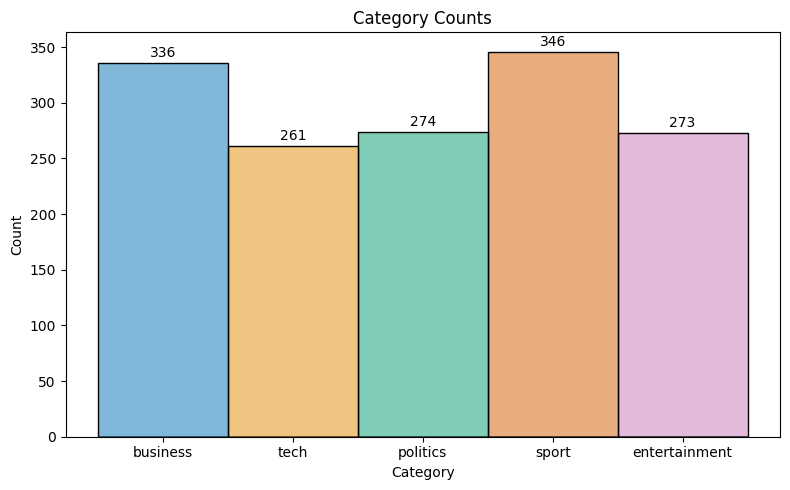

,count
Category,
sport,346
business,336
politics,274
entertainment,273
tech,261


In [111]:
# Helper function to annotate histogram bars
def annotate_histogram_bars(ax):
    for container in ax.containers:
        # Filter out bars with zero values
        non_zero_bars = remove_zero_bars(container)
        # Annotate the bars
        ax.bar_label(non_zero_bars, label_type='edge', padding=2)

def remove_zero_bars(ax_container):
    # Get indices of non-zero values
    non_zero_indices = np.where(ax_container.datavalues > 0)[0]
    # Filter the container to only include non-zero bars
    ax_container.datavalues = ax_container.datavalues[non_zero_indices]
    ax_container.patches = [ax_container.patches[i] for i in non_zero_indices]
    return ax_container

# Main plotting function
def plot_category_counts(train_df):
    print('\n\nNumber of articles per topic:\n')
    
    # Create a histogram plot
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(
        data=train_df,
        x='Category',
        hue='Category',
        palette='colorblind',
        legend=False,
        ax=ax
    ).set(title='Category Counts')
    
    # Annotate the bars
    annotate_histogram_bars(ax)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

    # Return the counts as a DataFrame
    category_counts = pd.DataFrame(train_df['Category'].value_counts())
    return category_counts


plot_category_counts(train_df)


 count     1490.000000
mean      2233.461745
std       1205.153358
min        501.000000
25%       1453.000000
50%       1961.000000
75%       2751.250000
max      18387.000000
Name: Text_len, dtype: float64 



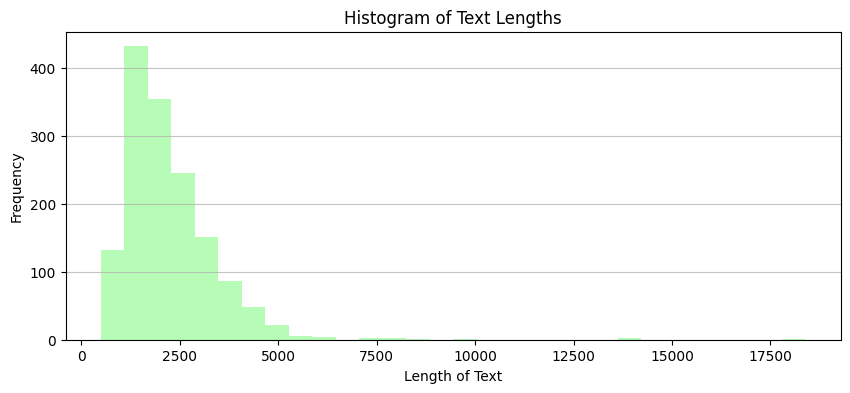

In [112]:
train_df["Text_len"] = train_df.Text.apply(lambda x: len(x))
print("\n", train_df["Text_len"].describe(), "\n")

plt.figure(figsize=(10, 4))
plt.hist(train_df["Text_len"], bins=30, color='palegreen', alpha=0.7)
plt.title('Histogram of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [113]:
# len(x) > 7,500
train_df["Text_len"] = train_df.Text.apply(lambda x: len(x))
count_above_10000 = (train_df["Text_len"] >= 7500).sum()
print(f"Length of text greater than or equal to 7,500: {count_above_10000}")

Length of text greater than or equal to 7,500: 8


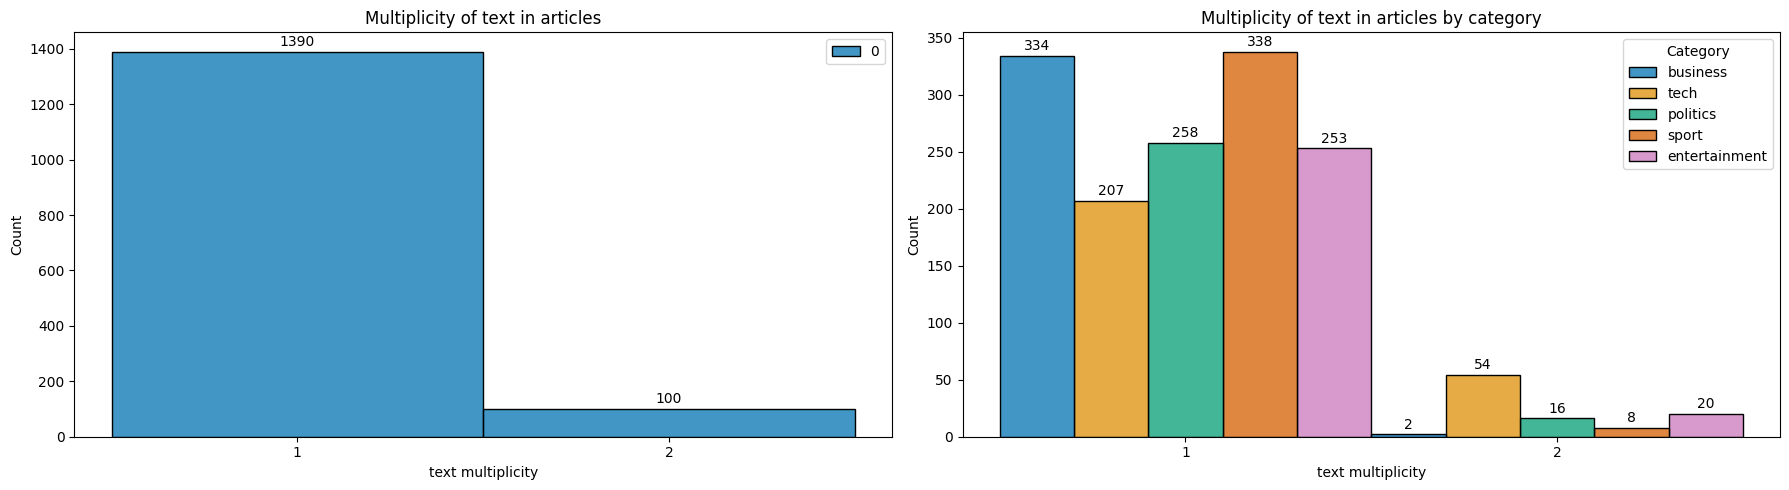

In [114]:
# Identify which categories contain most of the repeated text.
# Trim whitespace from the 'Text' column
train_df['Text'] = train_df['Text'].str.strip()

# Add column with multiplicity (as a string for prettier plots)
train_df['text multiplicity'] = train_df.groupby('Text')['Text'].transform('count').astype(str)

def plot_text_multiplicity(train_df):
    #print('What categories contain most of the repeated Text?')
    
    fig, ax = plt.subplots(ncols=2, figsize=(18, 5))
    
    # Helper function to create histograms
    def create_histogram(ax, data, title, hue=None):
        sns.histplot(
            ax=ax,
            data=data,
            x='text multiplicity',
            hue=hue,
            palette='colorblind',
            multiple='dodge',
            legend=True
        ).set(title=title)
        annotate_histogram_bars(ax)

    # Plot histograms
    create_histogram(ax[0], train_df, 'Multiplicity of text in articles', hue=0)
    create_histogram(ax[1], train_df, 'Multiplicity of text in articles by category', hue='Category')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_text_multiplicity(train_df)

# of repeated texts:   50 
Max # of different categories within repeated texts:    1 



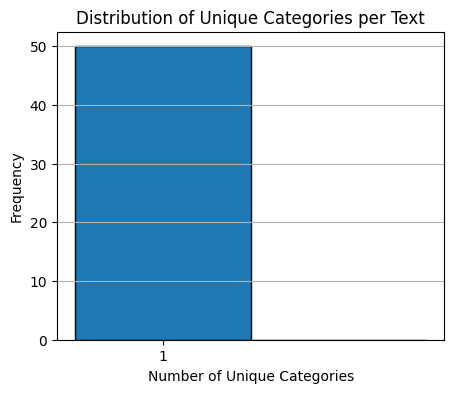

In [115]:
category_counts = train_df[train_df['text multiplicity'] != '1'].groupby('Text')['Category'].nunique()
print("# of repeated texts:  ", len(category_counts), "\nMax # of different categories within repeated texts:   ", category_counts.max(), "\n")

# The maximum number of different categories assigned to 50 repeated texts is: 
plt.figure(figsize=(5, 4))
plt.hist(category_counts, bins=range(1, category_counts.max() + 3), align='left', edgecolor='black')
plt.title('Distribution of Unique Categories per Text')
plt.xlabel('Number of Unique Categories')
plt.ylabel('Frequency')
plt.xticks(range(1, category_counts.max() + 1))
plt.grid(axis='y')
plt.show()

## 1.3 Data Cleaning

Number of articles per topic (without duplicates):


,count
Category,
sport,342
business,335
politics,266
entertainment,263
tech,234


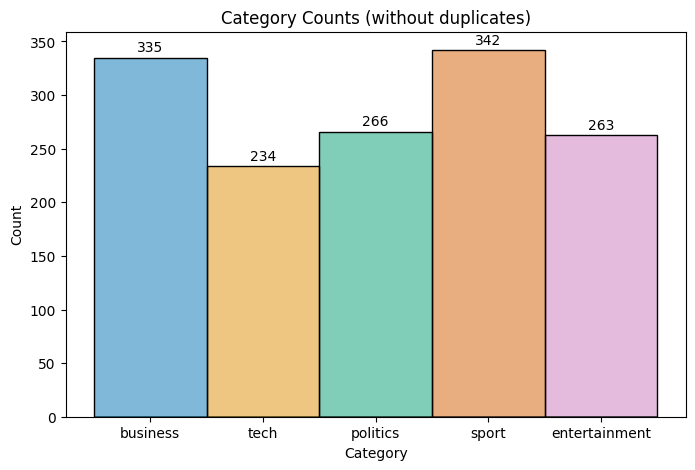

In [116]:
# remove duplicated articles.
train_df = train_df.drop_duplicates(subset=['Text'])
print('Number of articles per topic (without duplicates):')
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = train_df,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts (without duplicates)');
annotate_histogram_bars(ax)
pd.DataFrame(train_df['Category'].value_counts())

In [117]:
# Punctuation removal and treatment of words counts.
print('='*40)
print('Sample text:')
print('='*40)
print(train_df['Text'][4])

print('\n'+'='*40)
print('Frequency of punctuation marks in sample text:')
print('='*40)
[print("  {} is {} times".format(c,train_df['Text'][0].count(c))) for c in ['.',',',';','?',':','!','"',"'",")","("]];

from collections import Counter
print('\n'+'='*40)
print('Most common words in sample text:')
print('='*40)
for word, count in Counter(train_df['Text'][0].split()).most_common(4):
    print("  '{}' is {} times".format(word, count))

Sample text:
enron bosses in $168m payout eighteen former enron directors have agreed a $168m (£89m) settlement deal in a shareholder lawsuit over the collapse of the energy firm.  leading plaintiff  the university of california  announced the news  adding that 10 of the former directors will pay $13m from their own pockets. the settlement will be put to the courts for approval next week. enron went bankrupt in 2001 after it emerged it had hidden hundreds of millions of dollars in debt.  before its collapse  the firm was the seventh biggest public us company by revenue. its demise sent shockwaves through financial markets and dented investor confidence in corporate america.   the settlement is very significant in holding these outside directors at least partially personally responsible   william lerach  the lawyer leading the class action suit against enron  said.  hopefully  this will help send a message to corporate boardrooms of the importance of directors performing their legal dut

In [118]:
import re

def clean_text(df, keep_dots=False):
    """Cleans the column 'Text' in a DataFrame or Series."""
    clean_method = lambda x: clean_string(x, keep_dots)
    
    return df['Text'].apply(clean_method) if 'Text' in df else df.apply(clean_method)

def clean_string(s, keep_dots=False):
    """Cleans a string."""
    s = re.sub(r"\d+", " number ", s)  # Change numbers to the word "number"
    
    # Define translation table
    punctuation = "£,;:-" if keep_dots else "£.,;:-"
    s = s.translate(str.maketrans(punctuation, "$     ", "()+-*!?%"))  # Replace £ with $ and remove punctuation
    
    # Replace patterns
    replacements = {
        "$ number": "money",
        "number bn": "money",
        "money bn": "money",
        "money   money": "money",
        "money money": "money",
        "number   number": "number",
        "number number": "number"
    }
    
    for original, transformed in replacements.items():
        s = s.replace(original, transformed)
    
    return s

In [119]:
# Clean training set
pd.options.mode.chained_assignment = None
train_df['Text']=clean_text(train_df)
pd.options.mode.chained_assignment = "warn"

print('=== Sample texts after cleaning ===')
[print(train_df['Text'][i]+'\n') for i in range(2)];

=== Sample texts after cleaning ===
worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness   cynthia cooper  worldcom s exhead of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in  number   her warnings led to the collapse of the firm following the discovery of an money accounting fraud  mr ebbers has pleaded not guilty to charges of fraud and conspiracy   prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates  but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early  number  and  number   she said andersen had given a  green light  to the procedures an

## 1.4 Inspection of the Number of Words

In [120]:
pd.options.mode.chained_assignment = None
train_df['word count'] = train_df['Text'].apply(lambda row: len(row.split()))
train_df['char count'] = train_df['Text'].apply(lambda row: len(row))
pd.options.mode.chained_assignment = "warn"
print('Training set including number of word and number of characters per entry:')
train_df

Training set including number of word and number of characters per entry:


,ArticleId,Text,Category,Text_len,text multiplicity,word count,char count
0,1833,worldcom exboss launches defence lawyers defen...,business,1866,1,299,1879
1,154,german business confidence slides german busin...,business,2016,1,324,2053
2,1101,bbc poll indicates economic gloom citizens in ...,business,3104,1,511,3215
3,1976,lifestyle governs mobile choice faster bett...,tech,3618,1,631,3648
4,917,enron bosses in money m payout eighteen former...,business,2190,1,364,2235
...,...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1266,1,228,1329
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,3111,1,557,3162
1487,1590,weak dollar hits reuters revenues at media gro...,business,1370,1,242,1429
1488,1587,apple ipod family expands market apple has exp...,tech,3242,1,561,3318


count     1440.000000
mean      2234.261806
std       1211.698556
min        501.000000
25%       1451.250000
50%       1964.000000
75%       2754.000000
max      18387.000000
Name: Text_len, dtype: float64 /n


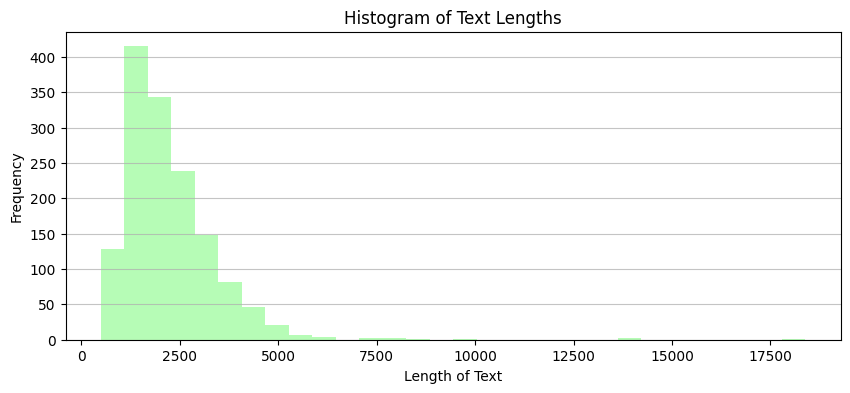

In [121]:
print(train_df["Text_len"].describe(), "/n")

plt.figure(figsize=(10, 4))
plt.hist(train_df["Text_len"], bins=30, color='palegreen', alpha=0.7)
plt.title('Histogram of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Length of text greater than or equal to 6000: 12
Remaining articles after removing those with text length >= 6000: 1428 



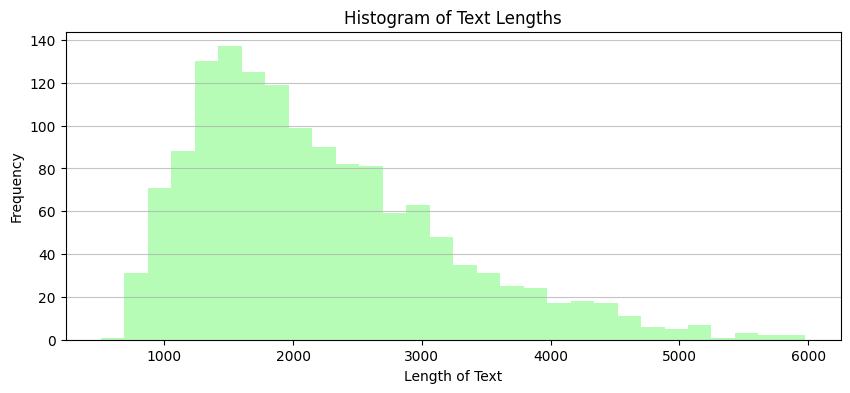

,ArticleId,Text,Category,Text_len,text multiplicity,word count,char count
0,1833,worldcom exboss launches defence lawyers defen...,business,1879,1,299,1879
1,154,german business confidence slides german busin...,business,2053,1,324,2053
2,1101,bbc poll indicates economic gloom citizens in ...,business,3215,1,511,3215
3,1976,lifestyle governs mobile choice faster bett...,tech,3648,1,631,3648
4,917,enron bosses in money m payout eighteen former...,business,2235,1,364,2235
...,...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1329,1,228,1329
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,3162,1,557,3162
1487,1590,weak dollar hits reuters revenues at media gro...,business,1429,1,242,1429
1488,1587,apple ipod family expands market apple has exp...,tech,3318,1,561,3318


In [122]:
train_df["Text_len"] = train_df.Text.apply(lambda x: len(x))
count_above_6000 = (train_df["Text_len"] >= 6000).sum()
print(f"Length of text greater than or equal to 6000: {count_above_6000}")

# Remove articles have length of text greater than or equal to 6000
train_df = train_df[train_df["Text_len"] < 6000]
remaining_count = train_df.shape[0]
print(f"Remaining articles after removing those with text length >= 6000: {remaining_count}", "\n")

plt.figure(figsize=(10, 4))
plt.hist(train_df["Text_len"], bins=30, color='palegreen', alpha=0.7)
plt.title('Histogram of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

train_df

=== Statistics about characters and word count in training set ===


,ArticleId,word count,char count
count,1428.000000,1428.000000,1428.000000
mean,1117.941176,374.307423,2202.813725
std,642.616586,165.409432,969.042040
min,2.000000,90.000000,507.000000
25%,560.750000,252.000000,1473.000000
50%,1109.500000,336.000000,1983.000000
75%,1681.250000,464.250000,2753.000000
max,2224.000000,1072.000000,5979.000000


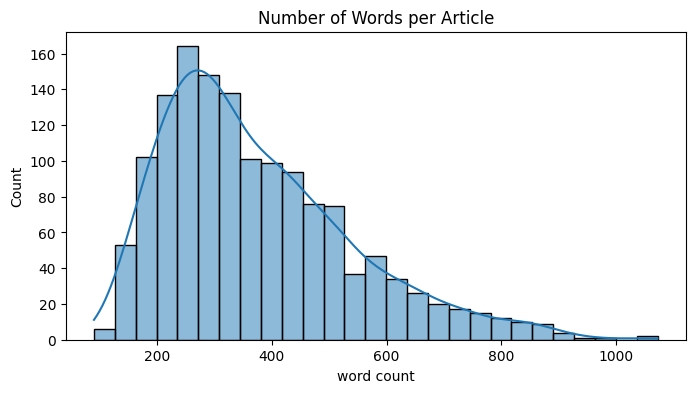

In [123]:
print('=== Statistics about characters and word count in training set ===')

train_df = train_df.drop(columns=['Text_len'])

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(
    data = train_df, 
    x = 'word count',
    kde=True,
    ).set(
        title = 'Number of Words per Article');

train_df.describe()

In [124]:
print('=== Word count statistics by category ===')
WC = train_df[['Category','word count']].groupby('Category')
WC.describe()

=== Word count statistics by category ===


word count                                                \
                   count        mean         std    min     25%    50%   
Category                                                                 
business           335.0  333.597015  132.663441  146.0  252.50  305.0   
entertainment      260.0  321.161538  139.339634  143.0  229.00  269.5   
politics           264.0  430.757576  146.438797   90.0  317.75  439.0   
sport              340.0  331.108824  161.895893  116.0  213.75  296.0   
tech               229.0  493.262009  182.638751  185.0  344.00  458.0   

                               
                  75%     max  
Category                       
business       388.50   907.0  
entertainment  375.75   941.0  
politics       524.00   982.0  
sport          413.25   864.0  
tech           631.00  1072.0

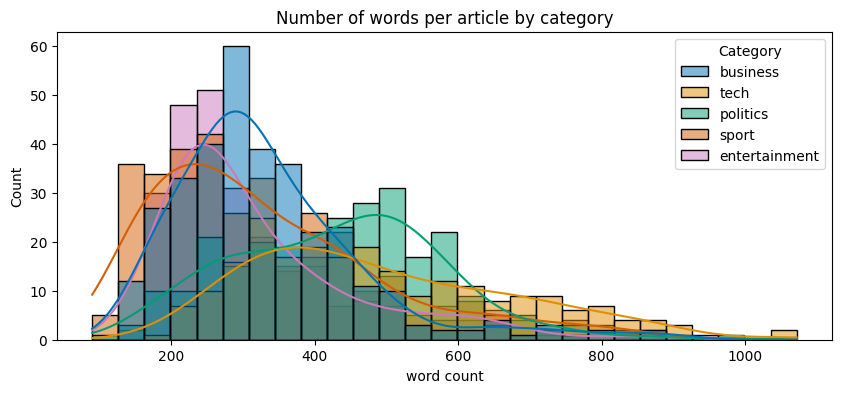

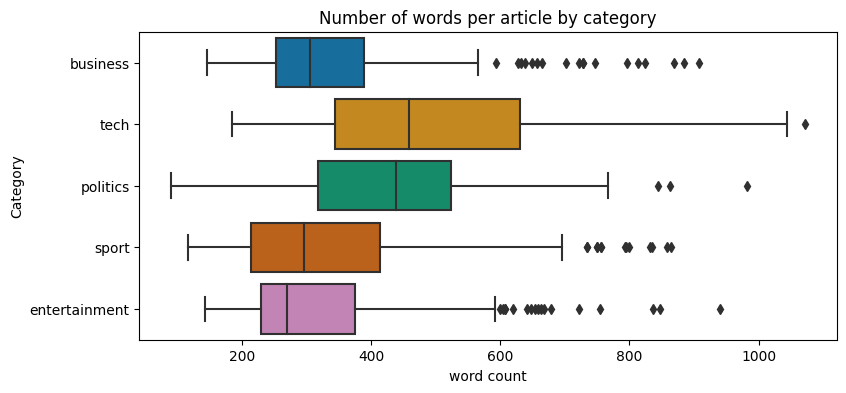

In [125]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(
    data = train_df, 
    x = 'word count',
    palette = 'colorblind',
    kde=True,
    hue = 'Category'
    ).set(
        title = 'Number of words per article by category');

# words per category
fig, ax = plt.subplots(figsize=(9, 4))
sns.boxplot(
    data = train_df, 
    x = 'word count', 
    y = 'Category',
    palette = 'colorblind'
    ).set(
        title = 'Number of words per article by category');

In [126]:
train_df['Text'][0]

'worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness   cynthia cooper  worldcom s exhead of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in  number   her warnings led to the collapse of the firm following the discovery of an money accounting fraud  mr ebbers has pleaded not guilty to charges of fraud and conspiracy   prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates  but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early  number  and  number   she said andersen had given a  green light  to the procedures and practices used by worldcom  mr eb

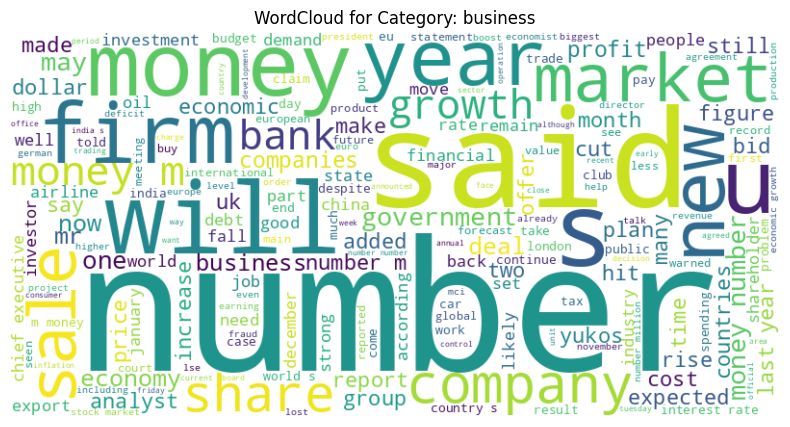

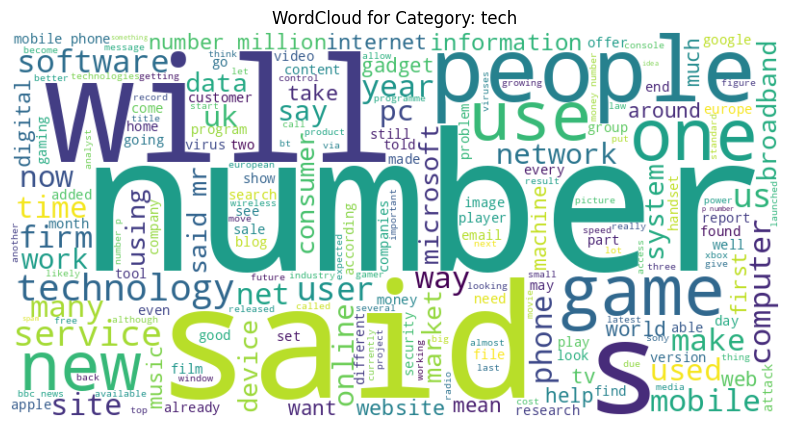

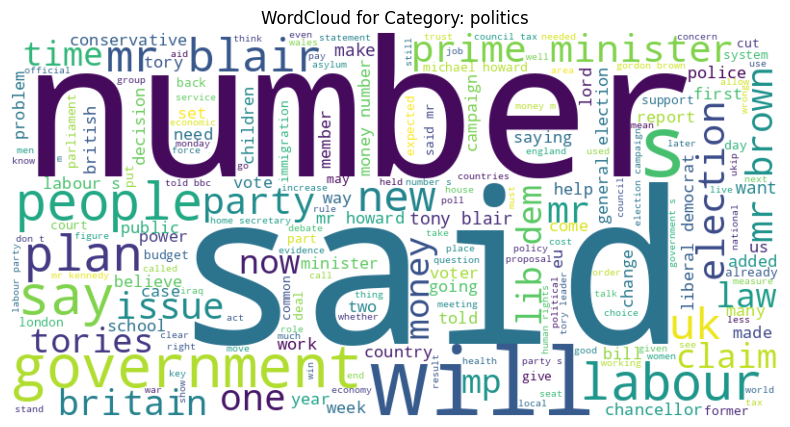

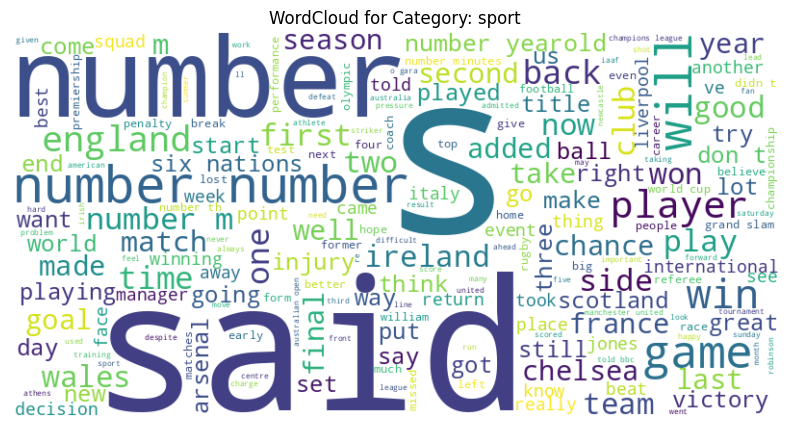

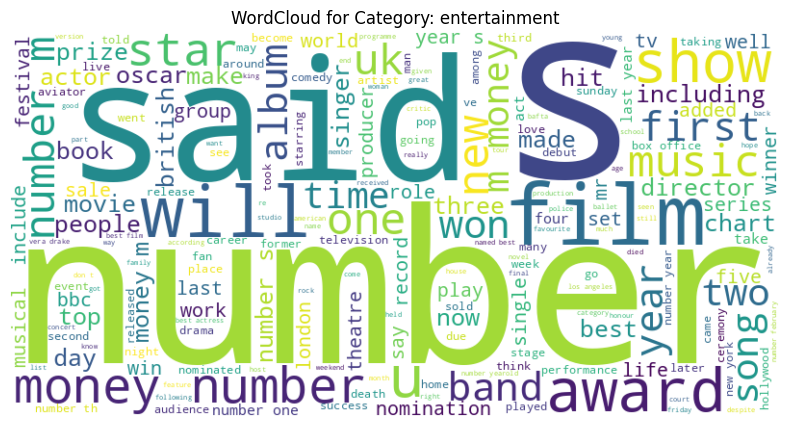

In [127]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

unique_categories = train_df['Category'].unique()

for category in unique_categories:

    text = ' '.join(train_df[train_df['Category'] == category]['Text'])
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Category: {category}")
    plt.show()


In [128]:
cv=CountVectorizer() 
txt=cv.fit_transform(train_df['Text'])
print('1) There are {} documents in the training set.'.format(len(train_df)))
print('2) There are {} different words in the training set.'.format(txt.shape[1]))
print('3) The Sparse Matrix of Text has size {} and its sparsity is {:.2f}%. '
      .format(txt.shape, 100 * (1 - txt.count_nonzero() / np.prod(txt.shape))))
print('\n=== Corresponding DataFrame:  The Sparse Matrix of Text ===')
counts_df = pd.DataFrame(txt.A,columns=cv.get_feature_names_out ())
counts_df

1) There are 1428 documents in the training set.
2) There are 24722 different words in the training set.
3) The Sparse Matrix of Text has size (1428, 24722) and its sparsity is 99.23%. 

=== Corresponding DataFrame:  The Sparse Matrix of Text ===


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abandon,...,zone,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
print('The most popular words among all documents are:')
print('\nword  count')
print('----------------')
print(counts_df.sum().sort_values().tail())
print('----------------')

The most popular words among all documents are:

word  count
----------------
in     11029
and    11457
of     12128
to     15446
the    32610
dtype: int64
----------------


In [130]:
# Include category column into word count
counts_df['_category_']=train_df['Category']

print('Word count by category:')
G = counts_df.groupby('_category_').sum()
G

Word count by category:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abandon,...,zone,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
_category_,,,,,,,,,,,,,,,,,,,,,
business,0,0,1,0,3,4,0,0,1,2,...,3,3,0,0,0,2,0,1,0,0
entertainment,0,0,0,0,0,0,1,1,0,0,...,3,0,1,1,1,0,0,1,0,3
politics,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
sport,1,3,1,0,0,0,0,0,1,0,...,4,1,0,1,0,0,1,2,0,1
tech,0,0,0,3,0,0,0,0,1,0,...,1,0,1,0,0,0,0,2,1,0


In [131]:
is_unique = G.astype(bool).sum(axis=0)==1

total_word_count = G.sum(axis=0)

a = total_word_count[is_unique]
b = G.idxmax(axis=0)[is_unique]
c = cv.get_feature_names_out ()[is_unique]

unique_words =  pd.DataFrame(data=zip(a,b),index=c,columns=['unique word count','Category'])
print('Unique words per category:')
unique_words.groupby('Category').describe()

Unique words per category:


unique word count                                              
                          count      mean       std  min  25%  50%  75%   max
Category                                                                     
business                 2976.0  1.420699  1.154791  1.0  1.0  1.0  1.0  16.0
entertainment            2071.0  1.397875  1.181204  1.0  1.0  1.0  1.0  24.0
politics                 1953.0  1.357399  1.030412  1.0  1.0  1.0  1.0  12.0
sport                    2968.0  1.445081  1.188793  1.0  1.0  1.0  1.0  13.0
tech                     1897.0  1.400105  1.321942  1.0  1.0  1.0  1.0  29.0

In [132]:
print('=== Top 10 Unique Words with Count per Category ===')
C = unique_words.groupby('Category')
U = C.max()
U['top unique word'] = C.idxmax().iloc[:, 0]
U
for category, g, in C:
    print('\nCategory: ', category,'\n', g['unique word count'].nlargest(10).to_markdown())

=== Top 10 Unique Words with Count per Category ===

Category:  business 
 |            |   unique word count |
|:-----------|--------------------:|
| mubanga    |                  16 |
| fsa        |                  14 |
| bets       |                  12 |
| godzilla   |                  12 |
| sunderland |                  12 |
| carnival   |                  11 |
| dtt        |                  11 |
| bravery    |                  10 |
| conti      |                  10 |
| monsanto   |                  10 |

Category:  entertainment 
 |          |   unique word count |
|:---------|--------------------:|
| uwb      |                  24 |
| leary    |                  13 |
| hoddle   |                  12 |
| nestle   |                  12 |
| ghosn    |                  11 |
| arnesen  |                   9 |
| jol      |                   9 |
| sella    |                   9 |
| sizzla   |                   9 |
| spurlock |                   9 |

Category:  politics 
 |         

In [133]:
print("'=== Unique Words's average appearance by Category ===")

for category, g, in C:
    print('\nCategory: ', category,'\n', g['unique word count'].mean())  
    
    article_count = train_df[train_df['Text'].str.contains('mubanga', na=False)].shape[0] 
print(f"Article numbers that appear words, 'mubanga': {article_count}")

'=== Unique Words's average appearance by Category ===

Category:  business 
 1.4206989247311828

Category:  entertainment 
 1.397875422501207

Category:  politics 
 1.357398873527906

Category:  sport 
 1.4450808625336926

Category:  tech 
 1.400105429625725
Article numbers that appear words, 'mubanga': 4


## 1.5 Conclusions After Inspecting Unique Word Count     

##### The original training set (after cleaning) contains $24,722$ different words and $1,428$ different articles about $5$ topics. $50$ repeated articles were removed. Length of text greater than or equal to $6,000$ also were cleaned.  

##### Some of those words are unique to each category. For instance, business has $2,976$ unique words, the most popular being unique word $'mubanga'$, which appears $16$ times in the $4$ unique articles belonging to $business$ category. 

##### On average, unique words per category appear $minimum 1.35$ and $maximum 1.42$ articles. Each unique is found in only a few articles, thus we cannot use unique words to build a simple classifier based on their presence.

##### Nonetheless, the presence of a unique word in an article is a strong indicator of the topic. A supervised model can use these unique words to classify articles into 5 topics, but they are not enough.

# 2. Extracting Word Features    

## 2.1 TF–IDF (Term Frequency - Inverse Document Frequency)     

To extracting Word Features, used TF–IDF to measure an importance of each word to a Category in dataset, accordingly adjusted for the fact that some words appear more frequently in general.

The TF-IDF is calculated by the product of $TF$ and $IDF$:     
**TF-IDF  =  $TF (Term Frequency)$ x $ IDF (Inverse Document Frequency)$**

The easy explanation is if some word appear frequently in document, it is important word to that document but not as important if it appears frequently across other documents. Therefore, tf-idf takes balance between 2 diffrent things, word's frequency in each document and its rarity across all documents.

**Term Frequency** measures the frequency of a word in a document.    
TF = (Number of times the term appears in a document) / (Total number of terms in the document)

**Inverse Document Frequency (IDF)** measures how important a term is in the entire documents.    
IDF = $log_e$(Total number of documents / Number of documents containing the term)

In the below inspection, found that in order to remove uninformative word like "the", "a(an)", approximated $min = 0.04, max = 0.45$ for TfidfVectorizer().  On top of that, to improve accuracy, while building models, explored what is the best parameters by using Greedy Search.


In [134]:
tfidf_transformer=TfidfTransformer()
txt_tf = tfidf_transformer.fit_transform(txt)

txt_tf_df = pd.DataFrame(txt_tf.A,columns = cv.get_feature_names_out ())
print('TF–IDF matrix of article text (txt_tf_df)\n')
txt_tf_df

TF–IDF matrix of article text (txt_tf_df)



,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abandon,...,zone,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
print('Word Scores Ranking in TF–IDF matrix (txt_tf_df)\n')
print(txt_tf_df.sum().sort_values())

Word Scores Ranking in TF–IDF matrix (txt_tf_df)

darabont       0.023449
flip           0.023449
outsiders      0.023449
sideway        0.023449
scoop          0.023449
                ...    
and          104.327361
in           104.650367
of           110.221418
to           140.601889
the          299.873960
Length: 24722, dtype: float64


Having the highest overall score in words like 'the', 'to', 'of', ... ---> Need to check "weight" because individual values does not have been appropiately weighted by the inverse term frequency

In [136]:
print("Weights given to words by IDF\n")
pd.DataFrame(tfidf_transformer.idf_,
             cv.get_feature_names_out (),
             columns=["idf_weights"]).sort_values(by="idf_weights")

Weights given to words by IDF



,idf_weights
the,1.000000
to,1.004208
of,1.007727
in,1.008433
and,1.010552
...,...
ja,7.571583
jaap,7.571583
jackal,7.571583
janmichael,7.571583


Common words like 'the' has idf_weigts, 1 that is the max value in idf_weights that is all non-informative and should be removed. And words appreas in all 5 categories are also not helpful to identify article category but se can inspect their frequency which might be helpful.
$$\int min  < {\frac{n}{N}} < \int max$$

Noticed that from the top 10 unique words per category, we got at least 8 ocurrences out of 1428 articles. In order not to remove those words, minimum value will be set 0.004
$$\int min  < {\frac{8}{1428}} = 0.0056$$

Accordingly we can divide the words into 3 categories (unique,intermideate,non-informative) and merge them into a dataframe with column type.

In [137]:
G.describe()

,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abandon,...,zone,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000
mean,0.200000,0.600000,0.400000,0.600000,0.600000,0.800000,0.200000,0.200000,0.600000,0.400000,...,2.400000,0.80000,0.400000,0.400000,0.200000,0.400000,0.200000,1.400000,0.200000,0.80000
std,0.447214,1.341641,0.547723,1.341641,1.341641,1.788854,0.447214,0.447214,0.547723,0.894427,...,1.341641,1.30384,0.547723,0.547723,0.447214,0.894427,0.447214,0.547723,0.447214,1.30384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,3.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,3.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.00000
max,1.000000,3.000000,1.000000,3.000000,3.000000,4.000000,1.000000,1.000000,1.000000,2.000000,...,4.000000,3.00000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,3.00000


In [138]:
all_category_words = G.astype(bool).sum(axis=0)==5
all_category_words

aa           False
aaa          False
aaas         False
aac          False
aadc         False
             ...  
zorro        False
zuluaga      False
zurich        True
zutons       False
zvonareva    False
Length: 24722, dtype: bool

In [139]:
universal_words = pd.DataFrame(txt.getnnz(axis=0)[all_category_words], # nnz = number of nonzero entries per column (count of articles with word)
                               index=G.columns[all_category_words]._data,
                               columns=['# of Articles with this word'])
universal_words

,# of Articles with this word
ability,58
able,164
about,612
above,38
abroad,26
...,...
youngsters,12
your,102
zealand,29
zone,11


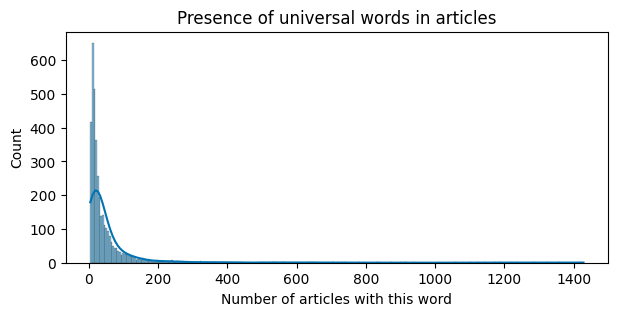

In [140]:
fig, axs = plt.subplots(ncols=1,figsize=(7, 3))
sns.histplot(
    ax=axs,
    data = universal_words, 
    legend = False,
    palette = 'colorblind',
    kde = True,
    ).set(
        title = 'Presence of universal words in articles',
        xlabel='Number of articles with this word');

In [141]:
print('=== 15 most common universal words ===')
print(universal_words.iloc[:,0].nlargest(15))
print("\nRemark: The word money is found in {} articles".format(universal_words.loc['money'][0]))
print("\nRemark: The word data is found in {} articles".format(universal_words.loc['data'][0]))

=== 15 most common universal words ===
the       1428
to        1422
of        1417
in        1416
and       1413
number    1358
for       1323
on        1284
it        1234
is        1227
said      1216
with      1190
that      1182
has       1173
was       1146
Name: # of Articles with this word, dtype: int64

Remark: The word money is found in 558 articles

Remark: The word data is found in 89 articles



Presence of words in articles by word type:



# of Articles with this word                                    \
                                    count       mean         std  min   25%   
type                                                                          
intermediate                       9031.0   4.350681    3.278650  1.0   2.0   
unique                            11865.0   1.119511    0.390434  1.0   1.0   
universal                          3826.0  57.700470  124.935107  5.0  14.0   

                                  
               50%   75%     max  
type                              
intermediate   3.0   5.0    48.0  
unique         1.0   1.0     5.0  
universal     24.0  52.0  1428.0

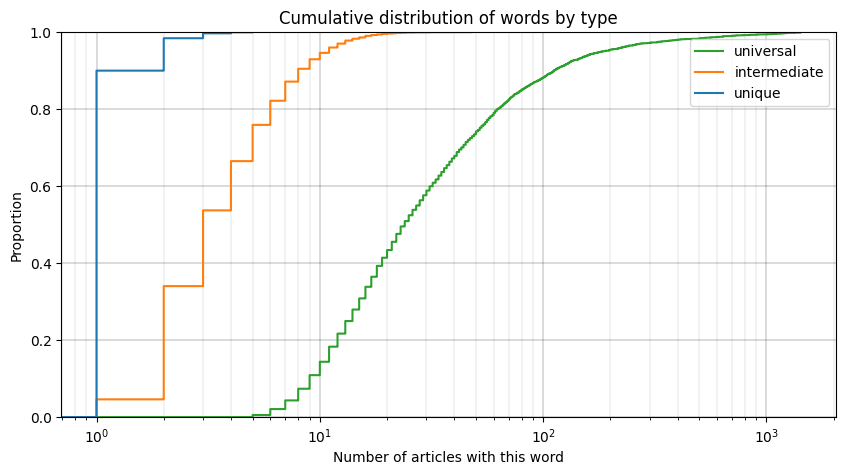

In [142]:
# Compute which words are unique, intermediate or universal

universal_words['type']='universal'
is_interm_freq_word = ~all_category_words & ~is_unique

intermediate_words =  pd.DataFrame(txt.getnnz(axis=0)[is_interm_freq_word], # nnz = number of nonzero entries per column (count of articles with word)
                               index=G.columns[is_interm_freq_word]._data,
                               columns=['# of Articles with this word'])
intermediate_words['type']='intermediate'

unique_words =  pd.DataFrame(txt.getnnz(axis=0)[is_unique], # nnz = number of nonzero entries per column (count of articles with word)
                               index=G.columns[is_unique]._data,
                               columns=['# of Articles with this word'])
unique_words['type']='unique' #defined in a previous cell.
word_types = pd.concat([unique_words,intermediate_words,universal_words],axis=0)

fig, axs = plt.subplots(ncols=1,figsize=(10, 5))
k=0
hue_order=['unique','intermediate','universal']
s=sns.ecdfplot(data = word_types,
             x= '# of Articles with this word',
             hue = "type",
             hue_order=hue_order,
             legend = False,                
             log_scale=(True,False),
          #   label = hue_order
            ).set(
        title = 'Cumulative distribution of words by type',
        xlabel='Number of articles with this word');

axs.grid(visible=True, which='major', color='black', linewidth=0.2)
axs.grid(visible=True, which='minor', color='black', linewidth=0.075)
axs.legend(labels=hue_order[::-1])
word_types = word_types.groupby('type')
print('\nPresence of words in articles by word type:\n')
word_types.describe()

In [143]:
counts_df

,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abandon,...,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva,_category_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,business
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,business
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,business
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,tech
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,politics
1424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,business
1425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,entertainment
1426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,politics


In [144]:
counts_df.info

<bound method DataFrame.info of       aa  aaa  aaas  aac  aadc  aaliyah  aaltra  aamir  aaron  abandon  ...  \
0      0    0     0    0     0        0       0      0      0        0  ...   
1      0    0     0    0     0        0       0      0      0        0  ...   
2      0    0     0    0     0        0       0      0      0        0  ...   
3      0    0     0    0     0        0       0      0      0        0  ...   
4      0    0     0    0     0        0       0      0      0        0  ...   
...   ..  ...   ...  ...   ...      ...     ...    ...    ...      ...  ...   
1423   0    0     0    0     0        0       0      0      0        0  ...   
1424   0    0     0    0     0        0       0      0      0        0  ...   
1425   0    0     0    0     0        0       0      0      0        0  ...   
1426   0    0     0    0     0        0       0      0      0        0  ...   
1427   0    0     0    0     0        0       0      0      0        0  ...   

      zones  zoom  

Boxplots of word count per category for chosen words:
The word 'money' is of universal type, found in 558 articles.
The word 'new' is of universal type, found in 635 articles.


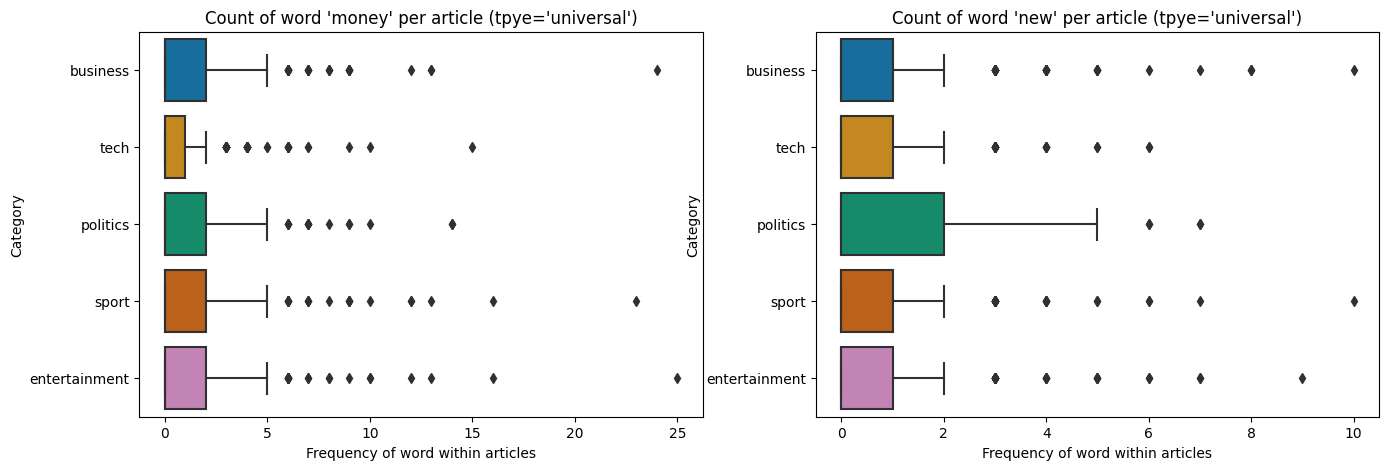

In [145]:
def get_word_type_and_count(word:str, word_types:pd.DataFrame):
    """ Returns a pandas series with word type and # of Articles with this word"""
    for word_type, group_df in word_types:
        try:
            return group_df.loc[word,:]
        except KeyError:
            pass
def print_word_type_and_count(word:str, word_types:pd.DataFrame):
    word_info = get_word_type_and_count(word, word_types)
    print("The word '{}' is of {} type, found in {} articles.".format(
        word, word_info['type'], word_info['# of Articles with this word']))     
print('Boxplots of word count per category for chosen words:')
fig, axs = plt.subplots(ncols=2,figsize=(16, 5));
words = ('money','new')
for i,word in enumerate(words):
    word_type = get_word_type_and_count(word,word_types)['type'];
    print_word_type_and_count(word,word_types)
    sns.boxplot(        
        ax = axs[i],
        data = counts_df, 
        x = word, 
        y = '_category_',
        palette = 'colorblind',    
        ).set(
            title = "Count of word '{}' per article (tpye='{}')".format(word,word_type),
            xlabel = 'Frequency of word within articles',
            ylabel = 'Category');

## 2.2 Conclusions from TF-IDF Words Counts Features     

We notice that the most popular intermediate frequency word is present in 48 articles only. If we were to build a classifier based on the sole presence of a word, we could actually set the higher bound close to 47/1428 when building the corresponding word matrix. However,  because we want to keep words that may have different frequencies within articles, let us set a higher threshold for  max  value (or we could take it as a hyperparameter and optimize it with cross validation).

An example of how different the frequency of a word within articles can provide information on the article topic is given below, where we inspect the distribution of the within article frequency of the word 'money'for each text category. For comparison purposes, we also plot the distribution of the much more common word 'new'.

Notice that articles about tech contain the word 'money' less often than others, so it is less likely that an article containing this word many times belongs to the 'sport' category. On the other hand, the word 'new' has the most ofen frequency in the politics.  As monetioned before word like 'the' is less informative, since marginal distributions by category are more similar to each other.

For the moment, we will fix max = 650/1428 = 0.45 
so that the word like 'money, new' are included. This will keep over 80% of the universal words, besides all unique and intermediate words.We can check that this will remove nearly 50 words from the training set. This is just a starting guess, which can later be improved preforming a grid search.

#  3. Unupervised Learning Method

In [146]:
%reset -f

In [147]:
# Basic packages
import numpy as np  
import pandas as pd  

import os
import sys
import gc

from time import perf_counter 
from tqdm import tqdm

# Cleaning
from nltk.corpus import stopwords
import string
import re
import warnings
warnings.simplefilter("ignore", FutureWarning)
from itertools import permutations, product, combinations
from functools import reduce

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer 
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, cross_val_score, train_test_split
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter

In [148]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [149]:
df_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
df_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
df_solution = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

## 3.1 Data Cleaning

In [150]:
punctuation = string.punctuation
df_train['Clean_Text'] = df_train['Text'].apply(lambda x: ''.join([i for i in x if i not in punctuation]).split())
df_test['Clean_Text'] = df_test['Text'].apply(lambda x: ''.join([i for i in x if i not in punctuation]).split())
df_train.head()

,ArticleId,Text,Category,Clean_Text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,"[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,"[enron, bosses, in, 168m, payout, eighteen, fo..."


In [151]:
stop_words = stopwords.words('english')
df_train['Clean_Text'] = df_train['Clean_Text'].apply(lambda x: ' '.join([i for i in x if i not in stop_words]))
df_test['Clean_Text'] = df_test['Clean_Text'].apply(lambda x: ' '.join([i for i in x if i not in stop_words]))
df_train.head()

,ArticleId,Text,Category,Clean_Text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses 168m payout eighteen former enron...


## 3.2 Unsupervised Learning Modeling (NMF)

In this part, tried unsupervised approach, especially the matrix factorization method (non-negative matrix factorization), to discover topics in the news articles and use the labels to check the accuracy. In general, the more labeled data we have, the more accurate the supervised learning model will be. But unsupervised learning can be powerful even when there is a small number of labels or no labels. For this, will build word count matrix with TF-IDF that we already inspect in the previous section 2 (Extracting Word Feature).

 $ X $ = $ W $ x $ H $ 

To compute $W$, and $H$ used NMF library from scikitlearn. In the section 2, we already estimated min 0.04, and max 0.45 in the TF-IDF.  With this base numbers, explored more to find if we couldn find the better parameters in the TF-IDF and also in the NMF with Greedy Search.


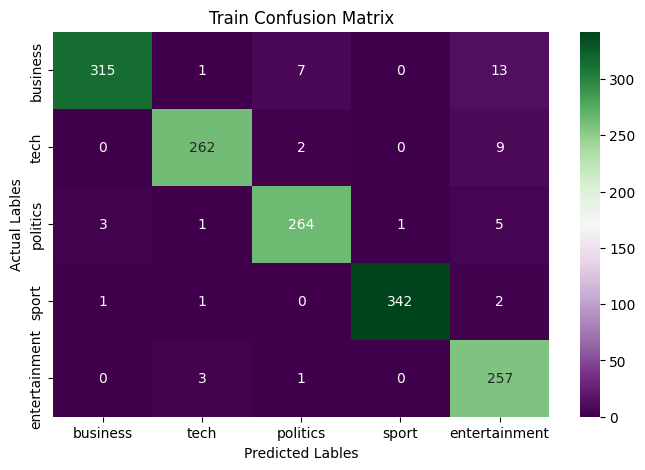

TF-IDF Options: {'min_df': 0.0015, 'max_df': 0.95, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)}
NMF Options:    {'n_components': 5, 'init': 'nndsvdar', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.3}
Train Accuracy: 96.64430%
----------------------------------------
Confusion Matrix:
 [[315   1   7   0  13]
 [  0 262   2   0   9]
 [  3   1 264   1   5]
 [  1   1   0 342   2]
 [  0   3   1   0 257]]


In [152]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.PRGn):
    """
    Function to plot a confusion matrix

    Args:
        cm (array): confusion matrix
        classes (list): class name
        title (str): plot title
        cmap: color map
    """
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual Lables')
    plt.xlabel('Predicted Lables')
    plt.show()

def execute_nmf_with_tfidf(train_data, test_data, tfidf_options, nmf_options):
    """
    Run TF-IDF vectorization and NMF and evaluate the performance.
    
    Args:
    train_data (pd.DataFrame): Training data with 'Clean_Text' and 'Category' columns.
    test_data (pd.DataFrame): Test data with 'Clean_Text' column.
    tfidf_options (dict): Parameters for TfidfVectorizer.
    nmf_options (dict): Parameters for NMF.

    Returns:
    dict: Dictionary containing train/test accuracies and parameters.
    """
    # Training
    tfidf_vectorizer = TfidfVectorizer(**tfidf_options)
    train_doc_term_matrix = tfidf_vectorizer.fit_transform(train_data['Clean_Text'])  # Fit TF-IDF to training data

    nmf_model = NMF(**nmf_options)
    nmf_model.fit(train_doc_term_matrix)  # Fit NMF to training data

    W_train = nmf_model.transform(train_doc_term_matrix)  # Transform training data

    # Test
    test_doc_term_matrix = tfidf_vectorizer.transform(test_data['Clean_Text'])  # Transform test data with the same TF-IDF model
    W_test = nmf_model.transform(test_doc_term_matrix)  # Transform test data with the same NMF model

    predicted_train_topics = np.argmax(W_train, axis=1)  # Find main topics of each document
    predicted_test_topics = np.argmax(W_test, axis=1)

    # Mapping topics to categories
    topic_to_category_map = {}
    for topic in range(nmf_model.n_components):
        topic_documents = [i for i, t in enumerate(predicted_train_topics) if t == topic]
        topic_categories = train_data.iloc[topic_documents]['Category']
        most_common_category = Counter(topic_categories).most_common(1)[0][0]
        topic_to_category_map[topic] = most_common_category

    predicted_train_categories = [topic_to_category_map[topic] for topic in predicted_train_topics]
    predicted_test_categories = [topic_to_category_map[topic] for topic in predicted_test_topics]

    # Accuracy
    train_accuracy = accuracy_score(train_data['Category'], predicted_train_categories)
    
    # Confusion Matrix
    train_confusion_matrix = confusion_matrix(train_data['Category'], predicted_train_categories)
    
    # Plotting Confusion Matrix
    plot_confusion_matrix(train_confusion_matrix, classes=train_data['Category'].unique(), title='Train Confusion Matrix')
    
    return {
        'tfidf_options': tfidf_options,
        'nmf_options': nmf_options,
        'train_accuracy': train_accuracy,
        'predicted_test_categories': predicted_test_categories,
        'train_confusion_matrix': train_confusion_matrix,
    }

# ----------------------------------------------------------------------------------------
#  Run with multiple sets of hyperparameters lik ebelow, with limited computing resources, 
#  after running multiple times, deactivated the other params except the best combination.
# ----------------------------------------------------------------------------------------
#    {'min_df': 0.01, 'max_df': 0.45, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.01, 'max_df': 0.50, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.01, 'max_df': 0.55, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.01, 'max_df': 0.60, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.04, 'max_df': 0.45, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.01, 'max_df': 0.65, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.01, 'max_df': 0.70, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.01, 'max_df': 0.75, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.01, 'max_df': 0.80, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.01, 'max_df': 0.85, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.01, 'max_df': 0.90, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},
#    {'min_df': 0.0015, 'max_df': 0.92, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)},

tfidf_param_grid = [
    {'min_df': 0.0015, 'max_df': 0.95, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)}
                   ]

#   {'n_components': 5, 'init': 'nndsvda', 'solver': 'mu', 'beta_loss': 'frobenius', 'l1_ratio': 0.5},
#   {'n_components': 5, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.3}

nmf_param_grid = [
    {'n_components': 5, 'init': 'nndsvdar', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.3}
]

# Iterate over parameter grid
results = []
for tfidf_options in tfidf_param_grid:
    for nmf_options in nmf_param_grid:
        result = execute_nmf_with_tfidf(df_train, df_test, tfidf_options, nmf_options)
        results.append(result)

# Print results
for res in results:
    print(f"TF-IDF Options: {res['tfidf_options']}")
    print(f"NMF Options:    {res['nmf_options']}")
    print(f"Train Accuracy: {res['train_accuracy'] * 100:.5f}%")
    print("-" * 40)

best_tfidf_result = max(results, key=lambda res: res['train_accuracy'])
best_categories = best_tfidf_result['predicted_test_categories']
best_cf = best_tfidf_result['train_confusion_matrix']
print(f"Confusion Matrix:\n {best_cf}")

submission_df = pd.DataFrame({
    'ArticleId': df_solution['ArticleId'],
    'Category': best_categories
})
submission_df.to_csv('submission.csv', index=False)

## 3.3 Test Accuracy of NMF


![Image](https://github.com/user-attachments/assets/d52f889c-bbea-476c-af0b-0f017c520b61)

In [153]:
print("-"*80)
print("Test Accuracy of NMF model in unsupervise learning:     0.97006")
print("-"*80)

--------------------------------------------------------------------------------
Test Accuracy of NMF model in unsupervise learning:     0.97006
--------------------------------------------------------------------------------


# 4. Supervised Learning Method

In this supervised learning, with labled (category) data, started with Logistic Regression, and Random Foresets.     
Found that Logistic Regression method was more accurate than Random Forests.     
After that, tried SVC that are the most efficient in these experiments, a simple task like BBC news classification.     

## 4.1 Supervised Learning Modeling (RF, LR, SVC)

For Supervised Learning methods, selected Logistic Regression, Random Forest Classifier, and Support Vector Classifier.
Like unsupervised learning, after vecterlization, then built models.

In [154]:
# Delete all variables
%reset -f

In [155]:
# Basic packages
import numpy as np  
import pandas as pd  

import os
import sys
import gc

from time import perf_counter 
from tqdm import tqdm

# Cleaning
from nltk.corpus import stopwords
import string
import re
import warnings
warnings.simplefilter("ignore", FutureWarning)
from itertools import permutations, product, combinations
from functools import reduce

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer 
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, cross_val_score, train_test_split
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter

In [156]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [157]:
df_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
df_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
df_solution = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

In [158]:
# Load and preprocess the dataset
train_data = df_train

# Create TF-IDF vector by using CountVectorizer, and TfidfTransformer 
pl = Pipeline([('count_vect', CountVectorizer()), ('tfidf', TfidfTransformer())])
X_train = pl.fit_transform(df_train['Text'])
X_test = pl.transform(df_test['Text'])
features = X_train
labels = train_data['Category']
print("Feature shape: ", X_train.shape)

X_train, y_train = features, labels

# Initialize the models
model_dict = {
    'Support Vector Classifier': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42)
}

# Different train sizes to evaluate
train_sizes = [0.1, 0.2, 0.5, 0.8, 1.0]

# Dictionary to store results
evaluation_results = {
    'Model': [],
    'Train Size': [],
    'Train Accuracy': []
}

for name, model in model_dict.items():
    print(f"Evaluating {name}")
    for size in train_sizes:
        subset_size = int(size * X_train.shape[0])
        
        # Fit the model
        model.fit(X_train[:subset_size], y_train[:subset_size])
        
        # Make predictions
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        
        # Calculate accuracies
        train_acc = accuracy_score(y_train, train_predictions)
                
        # Store the results
        evaluation_results['Model'].append(name)
        evaluation_results['Train Size'].append(f'{size * 100}%')
        evaluation_results['Train Accuracy'].append(f"{train_acc:.5%}")
        
supervised_results_df = pd.DataFrame(evaluation_results)
supervised_results_df

Feature shape:  (1490, 24746)
Evaluating Support Vector Classifier
Evaluating Logistic Regression
Evaluating Random Forest Classifier


,Model,Train Size,Train Accuracy
0,Support Vector Classifier,10.0%,64.29530%
1,Support Vector Classifier,20.0%,86.84564%
2,Support Vector Classifier,50.0%,98.45638%
3,Support Vector Classifier,80.0%,99.26174%
4,Support Vector Classifier,100.0%,100.00000%
5,Logistic Regression,10.0%,71.00671%
6,Logistic Regression,20.0%,88.99329%
7,Logistic Regression,50.0%,98.18792%
8,Logistic Regression,80.0%,98.92617%
9,Logistic Regression,100.0%,99.59732%


According to the experiment against different model type, and training data size, Support Vector Classifier with 100% training data set size shows the best result. 
On the 100% of the training data set, accuracy of the supervised learning performed better than the other sizes.  


The training accuracy both of the Support Vector Classifier and Random Forest Classifier were 100%. But on the 80% size of both model, Support Vector Classifier worked slighly better, thus my best model was set as SVC.

Finally, implemented SVC and explore params using Grid Search to find out if there were more rooms for further tunning, and submitted the final best version.

## 4.2 Test Accuracy of SVC before tuning

In [159]:
# 이전코드 SVC 모델 초기화
model = SVC(random_state=42)

# 모델 훈련
model.fit(features, labels)

# 예측 수행
pred = model.predict(X_test)

# 훈련 데이터에 대한 예측
train_pred = model.predict(features)

# 훈련 정확도 계산
train_accuracy = accuracy_score(df_train['Category'], train_pred)

# 결과 출력
print(f"Training Accuracy: {train_accuracy:.5f}")

Training Accuracy: 1.00000


In [160]:
submission = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')
submission['Category'] = pred
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [161]:
print("-"*80)
print("Test Accuracy of SVC model in supervise learning:     0.98231")
print("-"*80)

--------------------------------------------------------------------------------
Test Accuracy of SVC model in supervise learning:     0.98231
--------------------------------------------------------------------------------


### Submission Screenshot:   

![Image](https://github.com/user-attachments/assets/5f70f0db-fe81-4da7-9e82-cd997a8bf28e)

## 4.3 Test Accuracy of SVC after tuning

In [162]:
model = SVC()

# For tuning 
"""param_grid = {
    'C': [0.1, 1, 9.5, 10, 10.5, 100],  # 정규화 매개변수
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # 커널 계수
    'kernel': ['linear']  # 커널 종류
}"""

param_grid = {
    'C': [9.5, 9.4],  # 정규화 매개변수
    'gamma': ['scale'],  # 커널 계수
    'kernel': ['linear']  # 커널 종류
}
# Grid Search 초기화
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# 모델 훈련 (Grid Search)
grid_search.fit(features, labels)

# 최적의 하이퍼파라미터 출력
print("Best parameters found: ", grid_search.best_params_)

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
pred = best_model.predict(X_test)

# 훈련 데이터에 대한 예측
train_pred = best_model.predict(X_train)

# 훈련 정확도 계산
train_accuracy = accuracy_score(df_train['Category'], train_pred)


print(f"Training Accuracy: {train_accuracy:.5f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found:  {'C': 9.5, 'gamma': 'scale', 'kernel': 'linear'}
Training Accuracy: 1.00000


In [163]:
submission = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')
submission['Category'] = pred
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [165]:
print("-"*90)
print("Test Accuracy of SVC model in supervise learning (after params tuning):     0.98503")
print("-"*90)

------------------------------------------------------------------------------------------
Test Accuracy of SVC model in supervise learning (after params tuning):     0.98503
------------------------------------------------------------------------------------------


### Submission Screenshot:   

![Image](https://github.com/user-attachments/assets/6d5b065c-2508-4de4-907e-23121ab39fb3)
